# Predicting CD5

In this notebook, we will try to predict the CD5 index of various papers, provided by the alexandria3k package (https://github.com/dspinellis/alexandria3k). 

First we have to read the data from the SQLite database.

Since the database file is too large, we will read all our tables with sqlite and save them to .csv files, to save space. The SQL commands for each table were:

works: 'SELECT * FROM works'

cdindex: 'SELECT cd.* FROM works as w, cdindex as cd WHERE w.doi = cd.doi'

work_subjects : 'SELECT * FROM work_subjects'

work_authors: 'SELECT * FROM work_authors'

author_affiliations: 'SELECT * FROM author_affiliations'

work_references: 'SELECT * FROM work_references'

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
works_df = pd.read_csv("data/works.csv")
works_df

,id,published_month,abstract,title,published_day,doi,published_year
0,171,7.0,<jats:title>Abstract</jats:title><jats:p>The p...,On photolytic synthesis of sulphur-bearing org...,NaN,10.1017/s1473550406002904,2007.0
1,239,NaN,<jats:title>Abstract</jats:title><jats:p>Examp...,The potentially latent dominance of groundwate...,NaN,10.1144/gsl.eng.1986.003.01.02,1986.0
2,284,10.0,<jats:p> Acute hypoxia causes pulmonary vasoco...,Hypoxia divergently regulates production of re...,NaN,10.1152/ajplung.00203.2007,2007.0
3,299,8.0,<jats:title>Abstract</jats:title>\n ...,Noninvasive Tracking of Cardiac Embryonic Stem...,9.0,10.1634/stemcells.2007-0216,2007.0
4,373,8.0,<jats:title>Abstract</jats:title>\n ...,"Biphasic, but monolithic scaffolds for the the...",1.0,10.3139/146.101520,2007.0
...,...,...,...,...,...,...,...
149073,4477724,9.0,<jats:p>The nymphal instars I and III - V of S...,The nymphs of Sigara (Tropocorixa) denseconscr...,NaN,10.1590/s0073-47212013000300013,2013.0
149074,4489260,5.0,<jats:p> The possible effects of a wide range ...,Epidemiology of Intrathoracic Petechial Hemorr...,NaN,10.1007/s100249900027,1998.0
149075,4490759,2.0,"<jats:p>After electroconvulsive therapy (ECT),...",Verbal perseveration after right-unilateral ECT,NaN,10.1016/s0924-9338(00)00540-x,2001.0
149076,4491211,12.0,<jats:p>This article looks at the issue — larg...,Crucial relationship between the privatized se...,1.0,10.1016/s0967-067x(00)00019-2,2000.0


We would like to add columns to this dataframe, from other tables in our db, to make it rich enough to train our algorithms.

Firstly, we will read the CD5 indexes.

In [3]:
cd_index_df = pd.read_csv("data/cdindex.csv")
cd_index_df

,doi,cdindex
0,10.1016/s0924-9338(99)80691-9,-0.010811
1,10.1007/s100249900027,-0.007576
2,10.1590/s0073-47212013000300013,-0.100000
3,10.2166/ws.2013.162,1.000000
4,10.1152/ajpendo.00421.2013,-0.000258
...,...,...
137636,10.5005/jp-journals-10028-1097,0.000000
137637,10.2298/sarh1312794a,1.000000
137638,10.1525/ch.2014.91.1.10,NaN
137639,10.2478/s13382-014-0222-7,1.000000


We will now merge the cdindex to our works_df. This will be our target variable.

In [4]:
works_df = works_df.merge(cd_index_df,on='doi',how='inner')
works_df

,id,published_month,abstract,title,published_day,doi,published_year,cdindex
0,171,7.0,<jats:title>Abstract</jats:title><jats:p>The p...,On photolytic synthesis of sulphur-bearing org...,NaN,10.1017/s1473550406002904,2007.0,0.000000
1,239,NaN,<jats:title>Abstract</jats:title><jats:p>Examp...,The potentially latent dominance of groundwate...,NaN,10.1144/gsl.eng.1986.003.01.02,1986.0,0.000000
2,284,10.0,<jats:p> Acute hypoxia causes pulmonary vasoco...,Hypoxia divergently regulates production of re...,NaN,10.1152/ajplung.00203.2007,2007.0,-0.002938
3,299,8.0,<jats:title>Abstract</jats:title>\n ...,Noninvasive Tracking of Cardiac Embryonic Stem...,9.0,10.1634/stemcells.2007-0216,2007.0,-0.004497
4,373,8.0,<jats:title>Abstract</jats:title>\n ...,"Biphasic, but monolithic scaffolds for the the...",1.0,10.3139/146.101520,2007.0,-0.004373
...,...,...,...,...,...,...,...,...
137636,4477724,9.0,<jats:p>The nymphal instars I and III - V of S...,The nymphs of Sigara (Tropocorixa) denseconscr...,NaN,10.1590/s0073-47212013000300013,2013.0,-0.100000
137637,4489260,5.0,<jats:p> The possible effects of a wide range ...,Epidemiology of Intrathoracic Petechial Hemorr...,NaN,10.1007/s100249900027,1998.0,-0.007576
137638,4490759,2.0,"<jats:p>After electroconvulsive therapy (ECT),...",Verbal perseveration after right-unilateral ECT,NaN,10.1016/s0924-9338(00)00540-x,2001.0,-0.040000
137639,4491211,12.0,<jats:p>This article looks at the issue — larg...,Crucial relationship between the privatized se...,1.0,10.1016/s0967-067x(00)00019-2,2000.0,0.100000


Now we want to combine the published_month, published_year and published_day coulmns to one, date column.

Firstly, for all na values of the columns month and day, we will apply a value of 1.

In [5]:
works_df['published_month'].fillna(1,inplace=True)
works_df['published_day'].fillna(1,inplace=True)
works_df['publiced_date'] = pd.to_datetime(dict(year=works_df.published_year, month=works_df.published_month, day=works_df.published_day))
works_df.drop(axis=1,columns=['published_year','published_month','published_day'],inplace=True)

In [6]:
works_df

,id,abstract,title,doi,cdindex,publiced_date
0,171,<jats:title>Abstract</jats:title><jats:p>The p...,On photolytic synthesis of sulphur-bearing org...,10.1017/s1473550406002904,0.000000,2007-07-01
1,239,<jats:title>Abstract</jats:title><jats:p>Examp...,The potentially latent dominance of groundwate...,10.1144/gsl.eng.1986.003.01.02,0.000000,1986-01-01
2,284,<jats:p> Acute hypoxia causes pulmonary vasoco...,Hypoxia divergently regulates production of re...,10.1152/ajplung.00203.2007,-0.002938,2007-10-01
3,299,<jats:title>Abstract</jats:title>\n ...,Noninvasive Tracking of Cardiac Embryonic Stem...,10.1634/stemcells.2007-0216,-0.004497,2007-08-09
4,373,<jats:title>Abstract</jats:title>\n ...,"Biphasic, but monolithic scaffolds for the the...",10.3139/146.101520,-0.004373,2007-08-01
...,...,...,...,...,...,...
137636,4477724,<jats:p>The nymphal instars I and III - V of S...,The nymphs of Sigara (Tropocorixa) denseconscr...,10.1590/s0073-47212013000300013,-0.100000,2013-09-01
137637,4489260,<jats:p> The possible effects of a wide range ...,Epidemiology of Intrathoracic Petechial Hemorr...,10.1007/s100249900027,-0.007576,1998-05-01
137638,4490759,"<jats:p>After electroconvulsive therapy (ECT),...",Verbal perseveration after right-unilateral ECT,10.1016/s0924-9338(00)00540-x,-0.040000,2001-02-01
137639,4491211,<jats:p>This article looks at the issue — larg...,Crucial relationship between the privatized se...,10.1016/s0967-067x(00)00019-2,0.100000,2000-12-01


Then we are converting the dates to a format the algorithms will be able to read.

In [7]:
works_df['publiced_date'] = pd.to_datetime(works_df['publiced_date']).astype('int64') // 10**9
works_df

,id,abstract,title,doi,cdindex,publiced_date
0,171,<jats:title>Abstract</jats:title><jats:p>The p...,On photolytic synthesis of sulphur-bearing org...,10.1017/s1473550406002904,0.000000,1183248000
1,239,<jats:title>Abstract</jats:title><jats:p>Examp...,The potentially latent dominance of groundwate...,10.1144/gsl.eng.1986.003.01.02,0.000000,504921600
2,284,<jats:p> Acute hypoxia causes pulmonary vasoco...,Hypoxia divergently regulates production of re...,10.1152/ajplung.00203.2007,-0.002938,1191196800
3,299,<jats:title>Abstract</jats:title>\n ...,Noninvasive Tracking of Cardiac Embryonic Stem...,10.1634/stemcells.2007-0216,-0.004497,1186617600
4,373,<jats:title>Abstract</jats:title>\n ...,"Biphasic, but monolithic scaffolds for the the...",10.3139/146.101520,-0.004373,1185926400
...,...,...,...,...,...,...
137636,4477724,<jats:p>The nymphal instars I and III - V of S...,The nymphs of Sigara (Tropocorixa) denseconscr...,10.1590/s0073-47212013000300013,-0.100000,1377993600
137637,4489260,<jats:p> The possible effects of a wide range ...,Epidemiology of Intrathoracic Petechial Hemorr...,10.1007/s100249900027,-0.007576,893980800
137638,4490759,"<jats:p>After electroconvulsive therapy (ECT),...",Verbal perseveration after right-unilateral ECT,10.1016/s0924-9338(00)00540-x,-0.040000,980985600
137639,4491211,<jats:p>This article looks at the issue — larg...,Crucial relationship between the privatized se...,10.1016/s0967-067x(00)00019-2,0.100000,975628800


# Text Features

We will try to extract some features for our abstract and title that according to our papers are useful to predicting the cd index.

Firstly, we will remove the tags and will combine the abstract with our titles.

In [8]:
works_df['abstract'] = works_df['abstract'].str.replace(r'<[^<>]*>', ' ', regex=True)
works_df['text'] = works_df['title'] + ' ' + works_df['abstract']
works_df.drop(axis=1,columns=['abstract','title'],inplace=True)
works_df

,id,doi,cdindex,publiced_date,text
0,171,10.1017/s1473550406002904,0.000000,1183248000,On photolytic synthesis of sulphur-bearing org...
1,239,10.1144/gsl.eng.1986.003.01.02,0.000000,504921600,The potentially latent dominance of groundwate...
2,284,10.1152/ajplung.00203.2007,-0.002938,1191196800,Hypoxia divergently regulates production of re...
3,299,10.1634/stemcells.2007-0216,-0.004497,1186617600,Noninvasive Tracking of Cardiac Embryonic Stem...
4,373,10.3139/146.101520,-0.004373,1185926400,"Biphasic, but monolithic scaffolds for the the..."
...,...,...,...,...,...
137636,4477724,10.1590/s0073-47212013000300013,-0.100000,1377993600,The nymphs of Sigara (Tropocorixa) denseconscr...
137637,4489260,10.1007/s100249900027,-0.007576,893980800,Epidemiology of Intrathoracic Petechial Hemorr...
137638,4490759,10.1016/s0924-9338(00)00540-x,-0.040000,980985600,Verbal perseveration after right-unilateral EC...
137639,4491211,10.1016/s0967-067x(00)00019-2,0.100000,975628800,Crucial relationship between the privatized se...


According to the Nature paper, papers with higher counts of unique words and unique word pairs, are more likely to be less desruptive and have a higher CD5.

We will use CountVectorizer from sklearn, to count these unique words and word pairs for each text row.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer

CountVectorizer()

In [10]:
works_df.dropna(inplace=True)
vectorizer = CountVectorizer(stop_words='english',ngram_range=(1, 2),token_pattern=r'\b\w+\b', dtype=np.int64)
X = vectorizer.fit_transform(works_df['text'])

# Compute the word counts for each text
word_counts = X.sum(axis=1)

# Add the word counts to the original DataFrame
works_df['unique_word_pair_count'] = word_counts

In [11]:
works_df

,id,doi,cdindex,publiced_date,text,unique_word_pair_count
0,171,10.1017/s1473550406002904,0.000000,1183248000,On photolytic synthesis of sulphur-bearing org...,211
1,239,10.1144/gsl.eng.1986.003.01.02,0.000000,504921600,The potentially latent dominance of groundwate...,131
2,284,10.1152/ajplung.00203.2007,-0.002938,1191196800,Hypoxia divergently regulates production of re...,373
3,299,10.1634/stemcells.2007-0216,-0.004497,1186617600,Noninvasive Tracking of Cardiac Embryonic Stem...,383
4,373,10.3139/146.101520,-0.004373,1185926400,"Biphasic, but monolithic scaffolds for the the...",143
...,...,...,...,...,...,...
137636,4477724,10.1590/s0073-47212013000300013,-0.100000,1377993600,The nymphs of Sigara (Tropocorixa) denseconscr...,65
137637,4489260,10.1007/s100249900027,-0.007576,893980800,Epidemiology of Intrathoracic Petechial Hemorr...,401
137638,4490759,10.1016/s0924-9338(00)00540-x,-0.040000,980985600,Verbal perseveration after right-unilateral EC...,177
137639,4491211,10.1016/s0967-067x(00)00019-2,0.100000,975628800,Crucial relationship between the privatized se...,301


Next, the authors of the Nature paper, observed the frequence of use of certain words, for recent and old papers, that could be used to predict the CD5. those words are: 

'follow','treat','produce','report','determine','affect','measure','note','influence','study',
'base','induce','associate','mediate','improve','enhance','control','relate','increase'

We will use tf to get the frequency of each of these words on our texts.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
words = ['follow','treat','produce','report','determine','affect','measure','note','influence','study',
        'base','induce','associate','mediate','improve','enhance','control','relate','increase']
tfidf = TfidfVectorizer(use_idf=False, vocabulary=words)
tfidf.fit(works_df['text'])
freq_df = pd.DataFrame(tfidf.transform(works_df['text']).toarray(), columns=words)
works_df = pd.concat([works_df, freq_df], axis=1)
works_df

,id,doi,cdindex,publiced_date,text,unique_word_pair_count,follow,treat,produce,report,...,study,base,induce,associate,mediate,improve,enhance,control,relate,increase
0,171.0,10.1017/s1473550406002904,0.000000,1.183248e+09,On photolytic synthesis of sulphur-bearing org...,211.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,239.0,10.1144/gsl.eng.1986.003.01.02,0.000000,5.049216e+08,The potentially latent dominance of groundwate...,131.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,284.0,10.1152/ajplung.00203.2007,-0.002938,1.191197e+09,Hypoxia divergently regulates production of re...,373.0,0.000000,0.0,0.0,0.0,...,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107
3,299.0,10.1634/stemcells.2007-0216,-0.004497,1.186618e+09,Noninvasive Tracking of Cardiac Embryonic Stem...,383.0,0.707107,0.0,0.0,0.0,...,0.707107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,373.0,10.3139/146.101520,-0.004373,1.185926e+09,"Biphasic, but monolithic scaffolds for the the...",143.0,0.000000,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80267,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
80269,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
80271,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
80273,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


# Science Fields

On the Nature paper we saw how a scince field correlates to the decreasing CD5 index through the years. The Science field used were Social Sciences, Life Sciences, Physical Sciences and Technology. We are going to read the subjects table of the database for our works.

In [13]:
work_subjects_df = pd.read_csv('data/work_subjects.csv')
work_subjects_df

,work_id,name
0,171,Earth and Planetary Sciences (miscellaneous)
1,171,Space and Planetary Science
2,171,Physics and Astronomy (miscellaneous)
3,171,"Ecology, Evolution, Behavior and Systematics"
4,239,Geotechnical Engineering and Engineering Geology
...,...,...
234352,4489260,"Pediatrics, Perinatology and Child Health"
234353,4490759,Psychiatry and Mental health
234354,4491211,Sociology and Political Science
234355,4491211,Development


As we can see, the names of these subjects are more specific thatn the science fields we are looking for. We need to find a way to classify them to our 5 categories.

To do that we downloaded the excel from https://incites.help.clarivate.com/Content/Research-Areas/citation-topics.html . This included various topics, on a 3-level hierarchy: macro, meso and micro with macro beeing the most general.

Then, according to the subject category list provided on https://images.webofknowledge.com/images/help/WOS/hp_research_areas_easca.html , we manually added another, more genneric, column to our excel file, assigning these topics to the science field we wanted. 

We are going to read this excel file.

In [14]:
topics_df = pd.read_excel('data/CT_reclustering2022_new.xlsx')
topics_df

,Science Field,Macro-topic name,Meso-topic name
0,Life Sciences,Clinical & Life Sciences,Neuroscience
1,Life Sciences,Clinical & Life Sciences,Neuroscience
2,Life Sciences,Clinical & Life Sciences,Neuroscience
3,Life Sciences,Clinical & Life Sciences,Neuroscience
4,Life Sciences,Clinical & Life Sciences,Neuroscience
...,...,...,...
2452,Arts & Humanities,Arts & Humanities,Theater
2453,Arts & Humanities,Arts & Humanities,Theater
2454,Arts & Humanities,Arts & Humanities,Theater
2455,Arts & Humanities,Arts & Humanities,Translational Studies


We are going to use the last 2 column text to train an algorithm to classify other topics to the fields of the first column.

First, we are combining the text of these 2 columns.

In [15]:
topics_df['topic'] = topics_df['Macro-topic name'] + ' ' + topics_df['Meso-topic name']
topics_df.drop(axis=1,columns=['Macro-topic name','Meso-topic name'],inplace=True)
topics_df

,Science Field,topic
0,Life Sciences,Clinical & Life Sciences Neuroscience
1,Life Sciences,Clinical & Life Sciences Neuroscience
2,Life Sciences,Clinical & Life Sciences Neuroscience
3,Life Sciences,Clinical & Life Sciences Neuroscience
4,Life Sciences,Clinical & Life Sciences Neuroscience
...,...,...
2452,Arts & Humanities,Arts & Humanities Theater
2453,Arts & Humanities,Arts & Humanities Theater
2454,Arts & Humanities,Arts & Humanities Theater
2455,Arts & Humanities,Arts & Humanities Translational Studies


Then we are going to create a pipeline, including CountVectorizer, Tdidf that is going to train a MultinomialNB model.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

And we fit it with our training data.

In [17]:
text_clf.fit(topics_df.topic, topics_df['Science Field'])

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

Now, we can predict the Science field of our subjects.

In [18]:
work_subjects_df['field'] = text_clf.predict(work_subjects_df['name'])
work_subjects_df

,work_id,name,field
0,171,Earth and Planetary Sciences (miscellaneous),Physical Sciences
1,171,Space and Planetary Science,Physical Sciences
2,171,Physics and Astronomy (miscellaneous),Physical Sciences
3,171,"Ecology, Evolution, Behavior and Systematics",Life Sciences
4,239,Geotechnical Engineering and Engineering Geology,Physical Sciences
...,...,...,...
234352,4489260,"Pediatrics, Perinatology and Child Health",Life Sciences
234353,4490759,Psychiatry and Mental health,Life Sciences
234354,4491211,Sociology and Political Science,Social Sciences
234355,4491211,Development,Life Sciences


In [19]:
work_subjects_df['field'].value_counts()

Life Sciences        133721
Physical Sciences     57646
Social Sciences       24655
Technology            11860
Arts & Humanities      6475
Name: field, dtype: int64

For each paper on our works_df, we want to add a column for each field with 0 and 1 values, 0 if the paper doesn't include a subject of this field and 1 if it does.

In [20]:
work_subjects_df = pd.get_dummies(work_subjects_df,columns=['field'])
work_subjects_df.drop(axis=1,columns=['name'],inplace=True)
work_subjects_df = work_subjects_df.groupby(['work_id'],as_index=False).max()
work_subjects_df

,work_id,field_Arts & Humanities,field_Life Sciences,field_Physical Sciences,field_Social Sciences,field_Technology
0,171,0,1,1,0,0
1,239,0,0,1,0,0
2,284,0,1,0,0,0
3,299,0,1,0,0,0
4,373,0,1,1,0,0
...,...,...,...,...,...,...
101918,4477724,0,1,0,0,0
101919,4489260,0,1,0,0,0
101920,4490759,0,1,0,0,0
101921,4491211,0,1,0,1,0


In [21]:
works_df = works_df.merge(work_subjects_df,how='left',left_on='id',right_on='work_id')
works_df.drop(axis=1,columns=['work_id'],inplace=True)
works_df

,id,doi,cdindex,publiced_date,text,unique_word_pair_count,follow,treat,produce,report,...,improve,enhance,control,relate,increase,field_Arts & Humanities,field_Life Sciences,field_Physical Sciences,field_Social Sciences,field_Technology
0,171.0,10.1017/s1473550406002904,0.000000,1.183248e+09,On photolytic synthesis of sulphur-bearing org...,211.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,1.0,0.0,0.0
1,239.0,10.1144/gsl.eng.1986.003.01.02,0.000000,5.049216e+08,The potentially latent dominance of groundwate...,131.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
2,284.0,10.1152/ajplung.00203.2007,-0.002938,1.191197e+09,Hypoxia divergently regulates production of re...,373.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.707107,0.0,1.0,0.0,0.0,0.0
3,299.0,10.1634/stemcells.2007-0216,-0.004497,1.186618e+09,Noninvasive Tracking of Cardiac Embryonic Stem...,383.0,0.707107,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
4,373.0,10.3139/146.101520,-0.004373,1.185926e+09,"Biphasic, but monolithic scaffolds for the the...",143.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110059,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN
110060,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN
110061,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN
110062,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN


# University Affiliation

On the paper that introduced the CD5 index, there was found a correlation between the papers that were affiliated with universities, gonverments and firms. The strongest correlation was that of the university.

We will read the tables of our works' authors and their affiliations.

In [22]:
work_authors_df = pd.read_csv('data/work_authors.csv')
work_authors_df

,id,work_id,orcid
0,2801664,171,NaN
1,3915776,239,NaN
2,4653056,284,NaN
3,4653057,284,NaN
4,4653058,284,NaN
...,...,...,...
577209,73576595457,4490759,NaN
577210,73584001024,4491211,NaN
577211,73585934336,4491329,NaN
577212,73585934337,4491329,NaN


In [23]:
auth_affiliations_df = pd.read_csv('data/auth_af.csv')
auth_affiliations_df

,author_id,name
0,3915776,"Styperson House\nAdlington, Macclesfield, Ches..."
1,4898816,"Biomolecular Science Center, University of Cen..."
2,4898817,"Biomolecular Science Center, University of Cen..."
3,4898818,"Biomolecular Science Center, University of Cen..."
4,4898819,"Department of Pharmacology, Georgetown Univers..."
...,...,...
327641,73363030016,Museo Argentino de Ciencias Naturales 'Bernard...
327642,73552035840,Departments of Obstetrics and Gynaecology and ...
327643,73552035841,"Department of Paediatrics, University of Auckl..."
327644,73552035842,"Department of Paediatrics, University of Auckl..."


We will merge these 2 tables on the author id.

In [24]:
work_authors_df = auth_affiliations_df.merge(work_authors_df, left_on = 'author_id',right_on = 'id',how = 'inner')
work_authors_df.drop(axis=1,columns=['author_id','id','orcid'],inplace=True)
work_authors_df

,name,work_id
0,"Styperson House\nAdlington, Macclesfield, Ches...",239
1,"Biomolecular Science Center, University of Cen...",299
2,"Biomolecular Science Center, University of Cen...",299
3,"Biomolecular Science Center, University of Cen...",299
4,"Department of Pharmacology, Georgetown Univers...",299
...,...,...
327641,Museo Argentino de Ciencias Naturales 'Bernard...,4477724
327642,Departments of Obstetrics and Gynaecology and ...,4489260
327643,"Department of Paediatrics, University of Auckl...",4489260
327644,"Department of Paediatrics, University of Auckl...",4489260


Now, we will look for each work on our works_df, if its authors are affiliated with a university. Even if one of them is, the university_af column on works_df will get a value of 1. Else, it will be 0.

In [25]:
merged_df = works_df.merge(work_authors_df,left_on='id', right_on='work_id',how='left')
grouped_df = merged_df.groupby('work_id').agg({'name': lambda x: any(x.str.contains('University'))})
works_df = works_df.merge(grouped_df,left_on='id', right_on='work_id',how='left')
works_df['university_af'] = works_df['name'].apply(lambda x: 1 if isinstance(x, bool) and x else 0)
works_df.drop(axis=1,columns=['name'],inplace=True)
works_df

,id,doi,cdindex,publiced_date,text,unique_word_pair_count,follow,treat,produce,report,...,enhance,control,relate,increase,field_Arts & Humanities,field_Life Sciences,field_Physical Sciences,field_Social Sciences,field_Technology,university_af
0,171.0,10.1017/s1473550406002904,0.000000,1.183248e+09,On photolytic synthesis of sulphur-bearing org...,211.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0
1,239.0,10.1144/gsl.eng.1986.003.01.02,0.000000,5.049216e+08,The potentially latent dominance of groundwate...,131.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0
2,284.0,10.1152/ajplung.00203.2007,-0.002938,1.191197e+09,Hypoxia divergently regulates production of re...,373.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.707107,0.0,1.0,0.0,0.0,0.0,0
3,299.0,10.1634/stemcells.2007-0216,-0.004497,1.186618e+09,Noninvasive Tracking of Cardiac Embryonic Stem...,383.0,0.707107,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1
4,373.0,10.3139/146.101520,-0.004373,1.185926e+09,"Biphasic, but monolithic scaffolds for the the...",143.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110059,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.0,1.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,0
110060,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,0
110061,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,0
110062,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,0


# Citations

Of course, the number of papers a focal paper cites, according to the Nature paper, correlates to its CD5 index.

We will read the table from our db with the references.

In [26]:
work_ref_df = pd.read_csv('data/work_ref.csv')
work_ref_df

,article_title,year,work_id,doi
0,NaN,NaN,171,10.1039/a800286j
1,NaN,NaN,171,10.1016/s0032-0633(99)00053-7
2,NaN,NaN,171,10.1063/1.477559
3,NaN,1987,171,NaN
4,NaN,NaN,171,10.1016/0019-1035(89)90161-9
...,...,...,...,...
2852176,NaN,NaN,4491329,10.1001/archopht.1993.01090060049022
2852177,Dystrophia retinae pigmentosa —dyacusis syndro...,1970,4491329,NaN
2852178,NaN,NaN,4491329,10.1038/1192
2852179,NaN,NaN,4491329,10.1111/j.1399-0004.1983.tb00082.x


We will add a column on our works_df for the number of references each paper includes.

In [27]:
work_ref_count = work_ref_df.groupby('work_id')['doi'].count().reset_index()
work_ref_count.rename({'doi':'ref_count'},axis=1,inplace=True)
work_ref_count

,work_id,ref_count
0,171,21
1,239,3
2,284,59
3,299,64
4,373,16
...,...,...
73371,4477724,6
73372,4489260,19
73373,4490759,1
73374,4491211,7


In [28]:
works_df = works_df.merge(work_ref_count,left_on='id',right_on='work_id',how='left')
works_df

,id,doi,cdindex,publiced_date,text,unique_word_pair_count,follow,treat,produce,report,...,relate,increase,field_Arts & Humanities,field_Life Sciences,field_Physical Sciences,field_Social Sciences,field_Technology,university_af,work_id,ref_count
0,171.0,10.1017/s1473550406002904,0.000000,1.183248e+09,On photolytic synthesis of sulphur-bearing org...,211.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0,171.0,21.0
1,239.0,10.1144/gsl.eng.1986.003.01.02,0.000000,5.049216e+08,The potentially latent dominance of groundwate...,131.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0,239.0,3.0
2,284.0,10.1152/ajplung.00203.2007,-0.002938,1.191197e+09,Hypoxia divergently regulates production of re...,373.0,0.000000,0.0,0.0,0.0,...,0.0,0.707107,0.0,1.0,0.0,0.0,0.0,0,284.0,59.0
3,299.0,10.1634/stemcells.2007-0216,-0.004497,1.186618e+09,Noninvasive Tracking of Cardiac Embryonic Stem...,383.0,0.707107,0.0,0.0,0.0,...,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,1,299.0,64.0
4,373.0,10.3139/146.101520,-0.004373,1.185926e+09,"Biphasic, but monolithic scaffolds for the the...",143.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0,373.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110059,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
110060,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
110061,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
110062,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,...,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


# Data Preparation

We have the data we need and we need to prepare the dataframe for our algorithms.

First, we will drop the columns we don't need.

In [29]:
works_df.drop(axis=1,columns=['text','id','doi','work_id'],inplace=True)
works_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110064 entries, 0 to 110063
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   cdindex                  80278 non-null   float64
 1   publiced_date            80278 non-null   float64
 2   unique_word_pair_count   80278 non-null   float64
 3   follow                   80278 non-null   float64
 4   treat                    80278 non-null   float64
 5   produce                  80278 non-null   float64
 6   report                   80278 non-null   float64
 7   determine                80278 non-null   float64
 8   affect                   80278 non-null   float64
 9   measure                  80278 non-null   float64
 10  note                     80278 non-null   float64
 11  influence                80278 non-null   float64
 12  study                    80278 non-null   float64
 13  base                     80278 non-null   float64
 14  indu

We are ging to fill our na values with 0.

In [30]:
works_df.fillna(0,inplace=True)

# Decision Tree Regressor

The first machine learning algorithm we are using is a decision tree regressor.

We have to split our data to training and testing sets.

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
X = works_df.drop(axis=1,columns=['cdindex'])
Y = works_df['cdindex']
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

Let's first build a tree with max_depth of 1.

In [33]:
dec_tree = DecisionTreeRegressor(max_depth=1)
dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

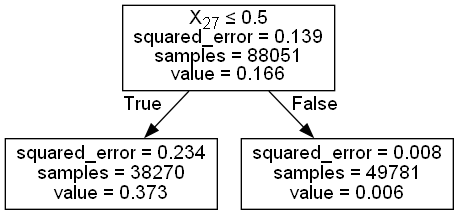

In [34]:
import graphviz
from IPython import display
from sklearn import tree
dot_data = tree.export_graphviz(dec_tree, 
                                out_file=None,
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
display.display_png(graph)

We will perform a search for the optimum tree depth since this one is too simple for our case.

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

parameters = [
  {'max_depth': list(range(1, 11))},
 ]

cv = KFold(n_splits=5, shuffle=True, random_state=13)
clf = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv)

clf = clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_params_)

DecisionTreeRegressor(max_depth=4)
{'max_depth': 4}


The best depth is 4

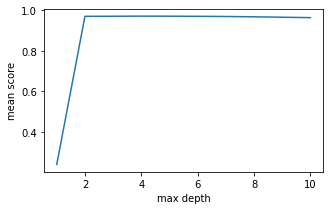

In [36]:
cv_results = pd.DataFrame(clf.cv_results_)
plt.figure(figsize=(5, 3))
plt.plot(cv_results['param_max_depth'], cv_results['mean_test_score'], label='True y')
plt.xlabel('max depth')
_ = plt.ylabel('mean score')

Let's see our tree.

In [37]:
dec_tree = DecisionTreeRegressor(max_depth=4)
dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

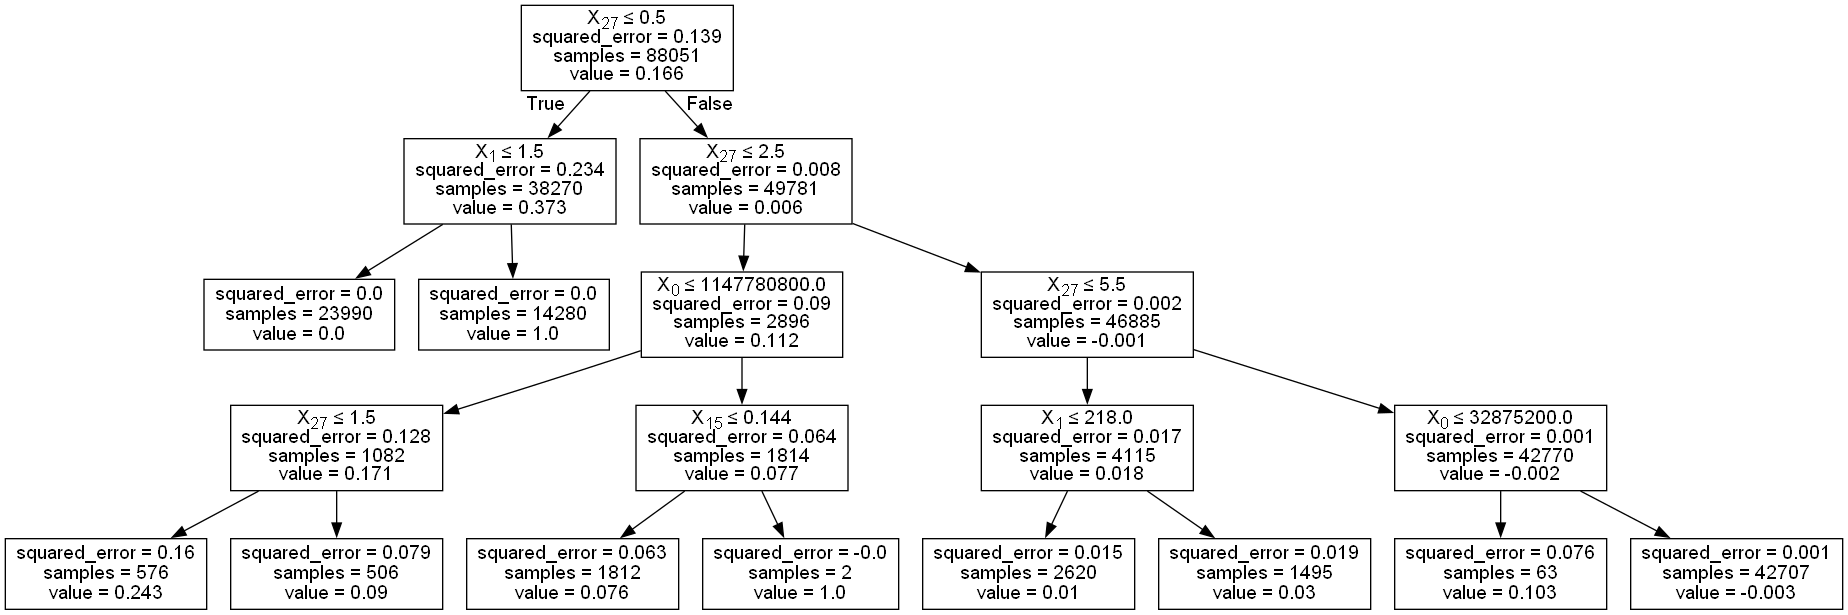

In [38]:
dot_data = tree.export_graphviz(dec_tree, 
                                out_file=None,
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
display.display_png(graph)

The R-Squared for our training set is:

In [39]:
dec_tree.score(X_train,y_train)

0.9712840765746209

The R-Squared for our testing set is:

In [40]:
dec_tree.score(X_test,y_test)

0.9745066692032666

Let's see how our predictions did in comparison to the true values.

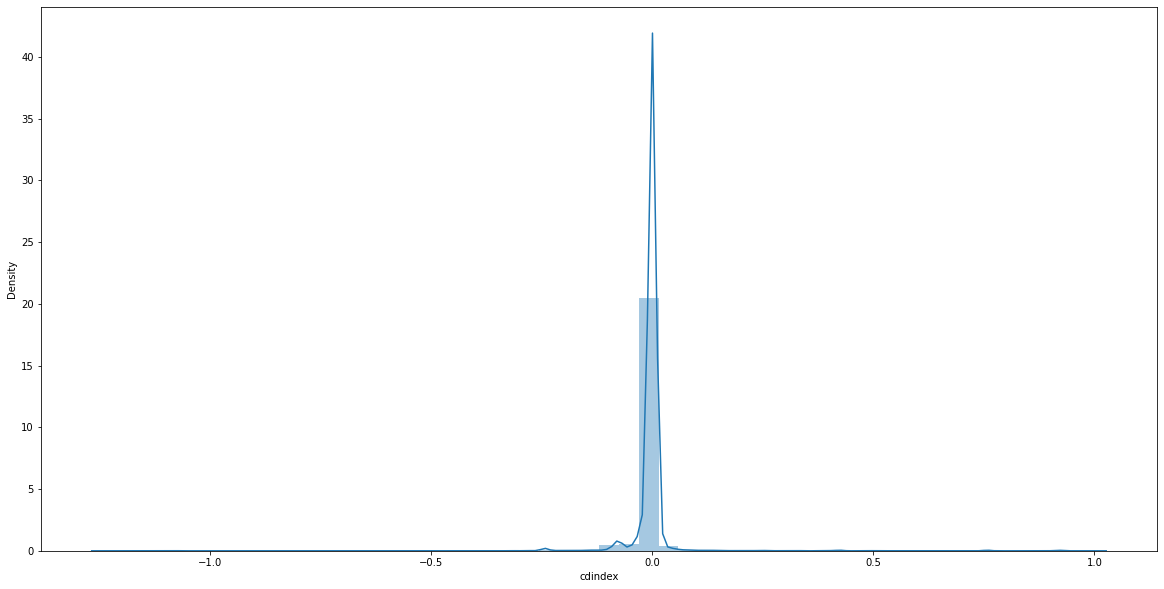

In [41]:
import seaborn as sns
prediction=dec_tree.predict(X_test)
plt.figure(figsize=(20, 10))
sns.distplot(y_test-prediction)
plt.show()

We can see that the distribution of our predictions is similar to the real values.

# Neural Network Regressor

With the same dataframe that we created for the papers, we will try to predict the CD5 index by using a neural network approach.

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
tf.random.set_seed(42)
model = keras.Sequential([
    keras.layers.Dense(64, input_shape=(28,), activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

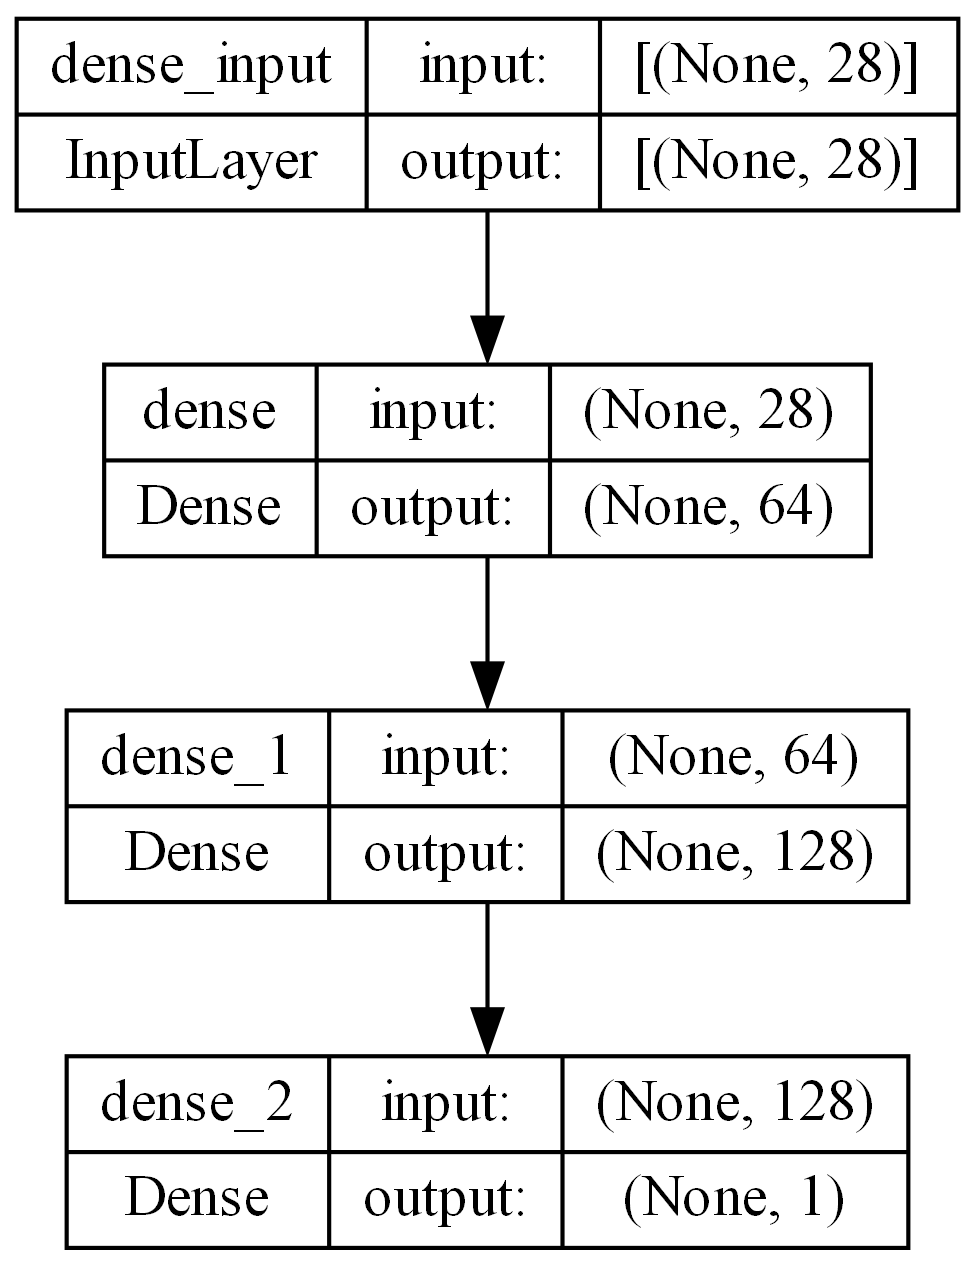

In [43]:
import IPython
from tensorflow.keras.utils import model_to_dot
IPython.display.Image(model_to_dot(model, 
                                   show_shapes=True, dpi=300).create(prog='dot', 
                                                                     format='png'),
                     width=300)

Our network, gets the 28 attributes of our dataframe as input. Then, it has 2 different hidden layers, one with 64 and one with 128 neurons. Finally, there is an output layer with one neuron. 

The activation function for the hidden layers is rectified linear unit (ReLU) and for the output layer is linear.

In [44]:
model.compile(loss='mean_absolute_error',
              optimizer='adam')

As a loss metric we will use the mean absolute error

We will also use the adam optimizer

Now we have to scale our data so they have equal impact on the models weights. We will use MinMaxScaler to get values from 0 to 1.

In [45]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# create scaler object
scaler = MinMaxScaler()

# fit scaler on data
scaler.fit(X)

# transform data
X = scaler.transform(X)

And we will split the data to training and testing sets

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

Now, before training our model, we will set an early stopping of 10 epochs. The model will stop improving if the validation set performance doesn't improve after 10 epochs, to avoid overfitting.

In [47]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

And we fit our model.

In [48]:
from sklearn.metrics import r2_score
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32,callbacks=[early_stop])

# make predictions on test set
y_pred = model.predict(X_test)

# calculate R-squared value
r2 = r2_score(y_test, y_pred)

print('R-squared:', r2)

Epoch 1/100
2752/2752 [==============================] - 7s 2ms/step - loss: 0.1566 - val_loss: 0.1407
Epoch 2/100
2752/2752 [==============================] - 6s 2ms/step - loss: 0.1328 - val_loss: 0.1202
Epoch 3/100
2752/2752 [==============================] - 5s 2ms/step - loss: 0.1026 - val_loss: 0.0820
Epoch 4/100
2752/2752 [==============================] - 5s 2ms/step - loss: 0.0609 - val_loss: 0.0464
Epoch 5/100
2752/2752 [==============================] - 6s 2ms/step - loss: 0.0443 - val_loss: 0.0354
Epoch 6/100
2752/2752 [==============================] - 6s 2ms/step - loss: 0.0360 - val_loss: 0.0313
Epoch 7/100
2752/2752 [==============================] - 6s 2ms/step - loss: 0.0315 - val_loss: 0.0323
Epoch 8/100
2752/2752 [==============================] - 5s 2ms/step - loss: 0.0277 - val_loss: 0.0240
Epoch 9/100
2752/2752 [==============================] - 5s 2ms/step - loss: 0.0258 - val_loss: 0.0227
Epoch 10/100
2752/2752 [==============================] - 5s 2ms/step - l

Our model stopped improving

The R-squared of the predictions on our testing set was:

In [49]:
print('R-squared:', r2)

R-squared: 0.9552217565807127


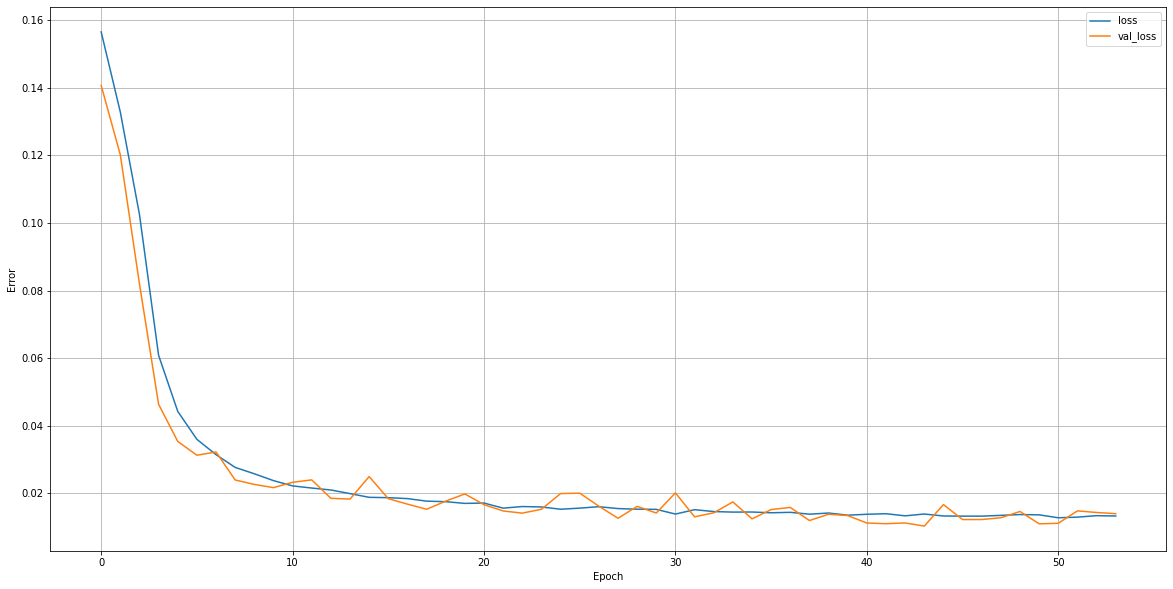

In [50]:
from matplotlib import pyplot as plt
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
def plot_loss(history):
    plt.figure(figsize=(20, 10))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
plot_loss(history)

Above we can see a plot of the training and validation set loss metric across the epochs.